In [1]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


### Import the Necessary Libraries :

In [30]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split, cross_val_score, RepeatedStratifiedKFold
from sklearn.neighbors import KNeighborsClassifier
from sklearn.svm import SVC
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from tabulate import tabulate
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, confusion_matrix
import time
import threading
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.compose import ColumnTransformer

In [31]:
data = pd.read_csv('/content/drive/MyDrive/heart.csv')
data.head()

,Age,Sex,ChestPainType,RestingBP,Cholesterol,FastingBS,RestingECG,MaxHR,ExerciseAngina,Oldpeak,ST_Slope,HeartDisease
0,40,M,ATA,140,289,0,Normal,172,N,0.00,Up,0
1,49,F,NAP,160,180,0,Normal,156,N,1.00,Flat,1
2,37,M,ATA,130,283,0,ST,98,N,0.00,Up,0
3,48,F,ASY,138,214,0,Normal,108,Y,1.50,Flat,1
4,54,M,NAP,150,195,0,Normal,122,N,0.00,Up,0


### Data Info :

In [32]:
data.shape

(918, 12)

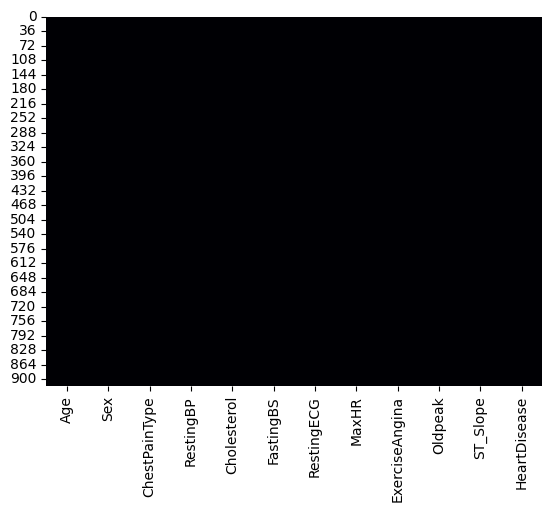

In [33]:
sns.heatmap(data.isnull(),cmap = 'magma',cbar = False);

- **No null values** present in the data!

In [34]:
data.describe().T

,count,mean,std,min,25%,50%,75%,max
Age,918.00,53.51,9.43,28.00,47.00,54.00,60.00,77.00
RestingBP,918.00,132.40,18.51,0.00,120.00,130.00,140.00,200.00
Cholesterol,918.00,198.80,109.38,0.00,173.25,223.00,267.00,603.00
FastingBS,918.00,0.23,0.42,0.00,0.00,0.00,0.00,1.00
MaxHR,918.00,136.81,25.46,60.00,120.00,138.00,156.00,202.00
Oldpeak,918.00,0.89,1.07,-2.60,0.00,0.60,1.50,6.20
HeartDisease,918.00,0.55,0.50,0.00,0.00,1.00,1.00,1.00


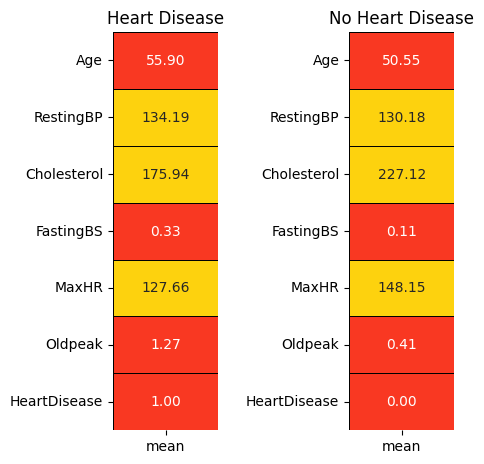

In [35]:
yes = data[data['HeartDisease'] == 1].describe().T
no = data[data['HeartDisease'] == 0].describe().T
colors = ['#F93822','#FDD20E']

fig,ax = plt.subplots(nrows = 1,ncols = 2,figsize = (5,5))
plt.subplot(1,2,1)
sns.heatmap(yes[['mean']],annot = True,cmap = colors,linewidths = 0.4,linecolor = 'black',cbar = False,fmt = '.2f',)
plt.title('Heart Disease');

plt.subplot(1,2,2)
sns.heatmap(no[['mean']],annot = True,cmap = colors,linewidths = 0.4,linecolor = 'black',cbar = False,fmt = '.2f')
plt.title('No Heart Disease');

fig.tight_layout(pad = 2)

### Dividing features into Numerical and Categorical :

In [36]:
col = list(data.columns)
categorical_features = []
numerical_features = []
for i in col:
    if len(data[i].unique()) > 6:
        numerical_features.append(i)
    else:
        categorical_features.append(i)

print('Categorical Features :',*categorical_features)
print('Numerical Features :',*numerical_features)

Categorical Features : Sex ChestPainType FastingBS RestingECG ExerciseAngina ST_Slope HeartDisease
Numerical Features : Age RestingBP Cholesterol MaxHR Oldpeak


### Categorical Features :

In [37]:
from sklearn.preprocessing import LabelEncoder
le = LabelEncoder()
df1 = data.copy(deep = True)

df1['Sex'] = le.fit_transform(df1['Sex'])
df1['ChestPainType'] = le.fit_transform(df1['ChestPainType'])
df1['RestingECG'] = le.fit_transform(df1['RestingECG'])
df1['ExerciseAngina'] = le.fit_transform(df1['ExerciseAngina'])
df1['ST_Slope'] = le.fit_transform(df1['ST_Slope'])

#### Distribution of Categorical Features :

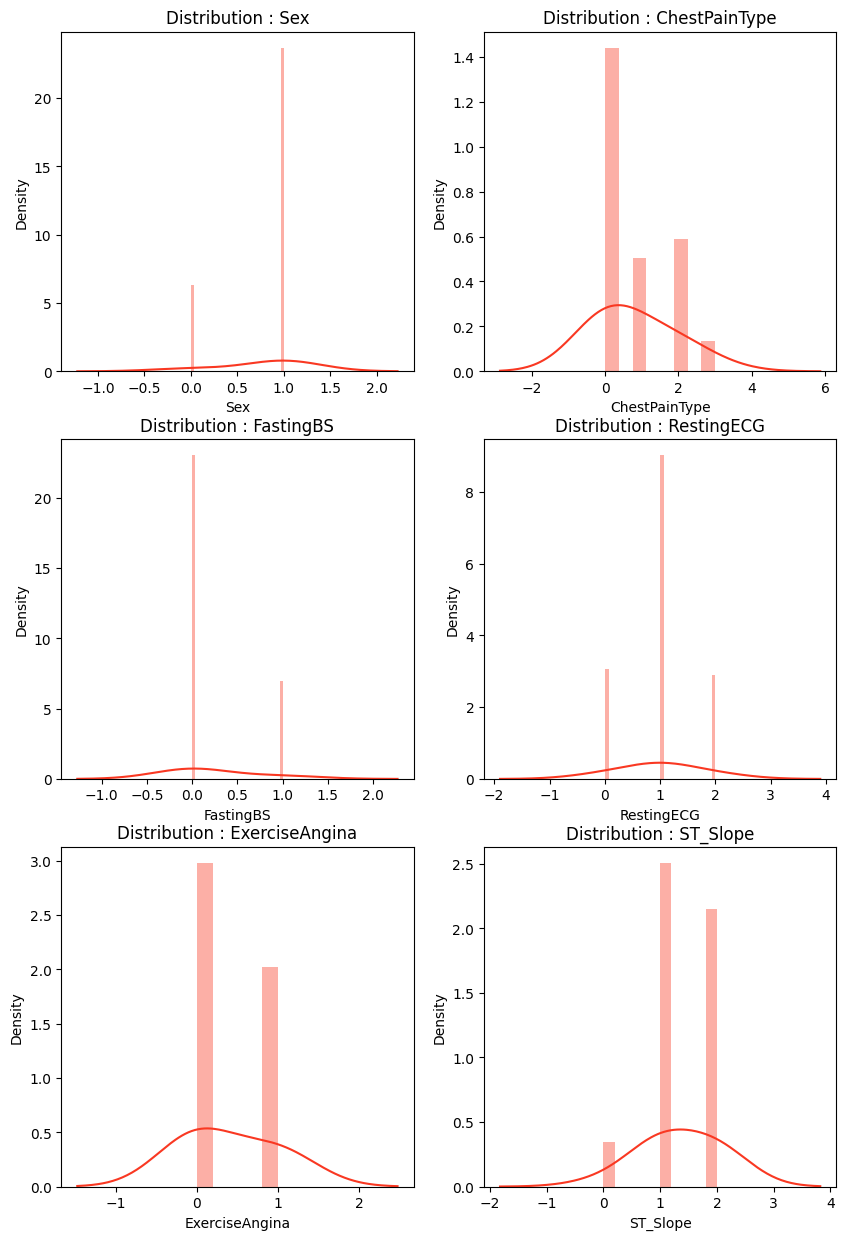

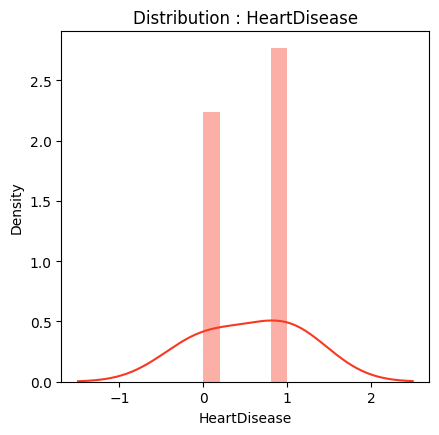

In [38]:
fig, ax = plt.subplots(nrows = 3,ncols = 2,figsize = (10,15))
for i in range(len(categorical_features) - 1):

    plt.subplot(3,2,i+1)
    sns.distplot(df1[categorical_features[i]],kde_kws = {'bw' : 1},color = colors[0]);
    title = 'Distribution : ' + categorical_features[i]
    plt.title(title)

plt.figure(figsize = (4.75,4.55))
sns.distplot(df1[categorical_features[len(categorical_features) - 1]],kde_kws = {'bw' : 1},color = colors[0])
title = 'Distribution : ' + categorical_features[len(categorical_features) - 1]
plt.title(title);

### Numerical Features :

#### Distribution of Numerical Features :

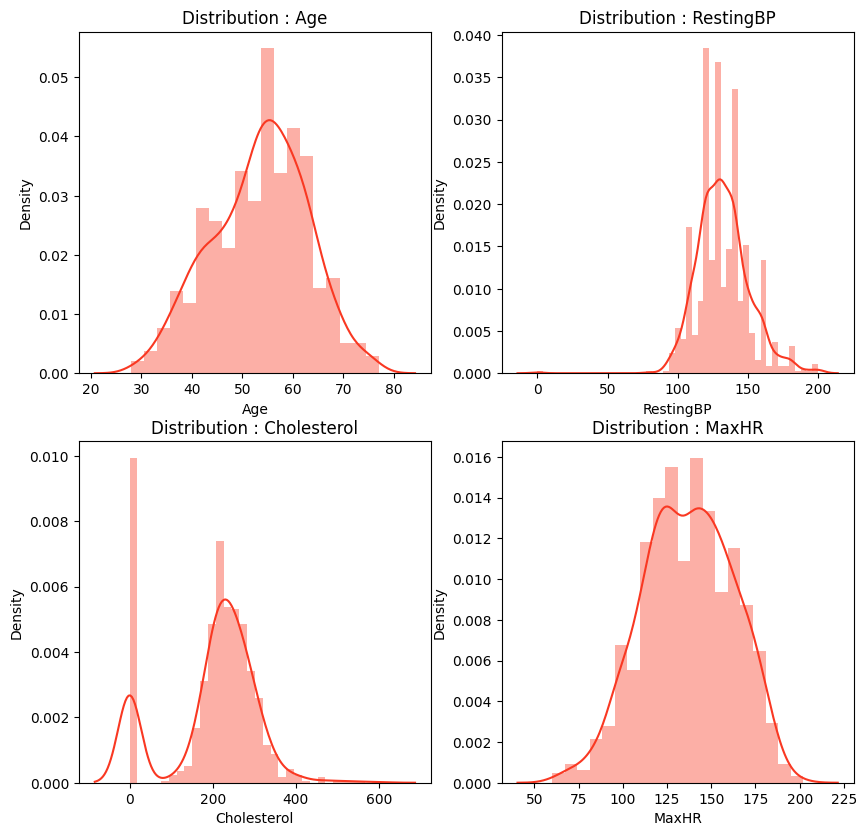

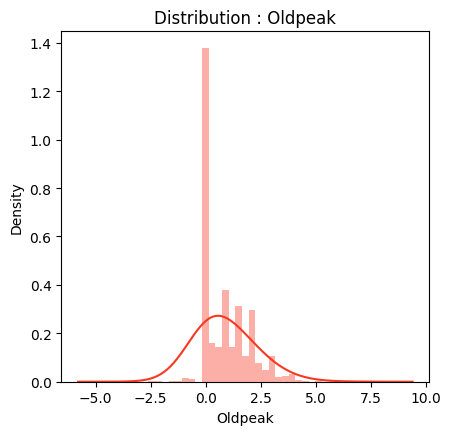

In [39]:
fig, ax = plt.subplots(nrows = 2,ncols = 2,figsize = (10,9.75))
for i in range(len(numerical_features) - 1):
    plt.subplot(2,2,i+1)
    sns.distplot(data[numerical_features[i]],color = colors[0])
    title = 'Distribution : ' + numerical_features[i]
    plt.title(title)
plt.show()

plt.figure(figsize = (4.75,4.55))
sns.distplot(df1[numerical_features[len(numerical_features) - 1]],kde_kws = {'bw' : 1},color = colors[0])
title = 'Distribution : ' + numerical_features[len(numerical_features) - 1]
plt.title(title);

### Target Variable Visualization (HeartDisease) :

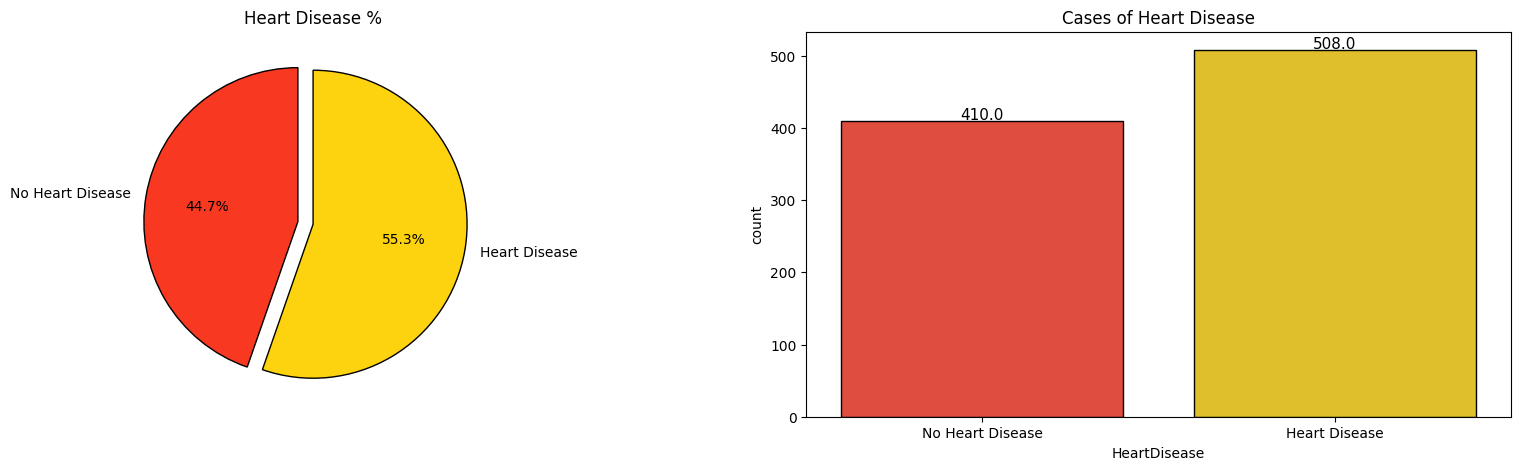

In [40]:
l = list(data['HeartDisease'].value_counts())
circle = [l[1] / sum(l) * 100, l[0] / sum(l) * 100]

fig, ax = plt.subplots(nrows=1, ncols=2, figsize=(20, 5))
plt.subplot(1, 2, 1)
plt.pie(circle, labels=['No Heart Disease', 'Heart Disease'], autopct='%1.1f%%', startangle=90, explode=(0.1, 0),
        colors=colors, wedgeprops={'edgecolor': 'black', 'linewidth': 1, 'antialiased': True})
plt.title('Heart Disease %')

plt.subplot(1, 2, 2)
ax = sns.countplot(x='HeartDisease', data=data, palette=colors, edgecolor='black')
for rect in ax.patches:
    ax.text(rect.get_x() + rect.get_width() / 2, rect.get_height() + 2, rect.get_height(), horizontalalignment='center', fontsize=11)
ax.set_xticklabels(['No Heart Disease', 'Heart Disease'])
plt.title('Cases of Heart Disease')
plt.show()

### Categorical Features vs Target Variable (HeartDisease) :

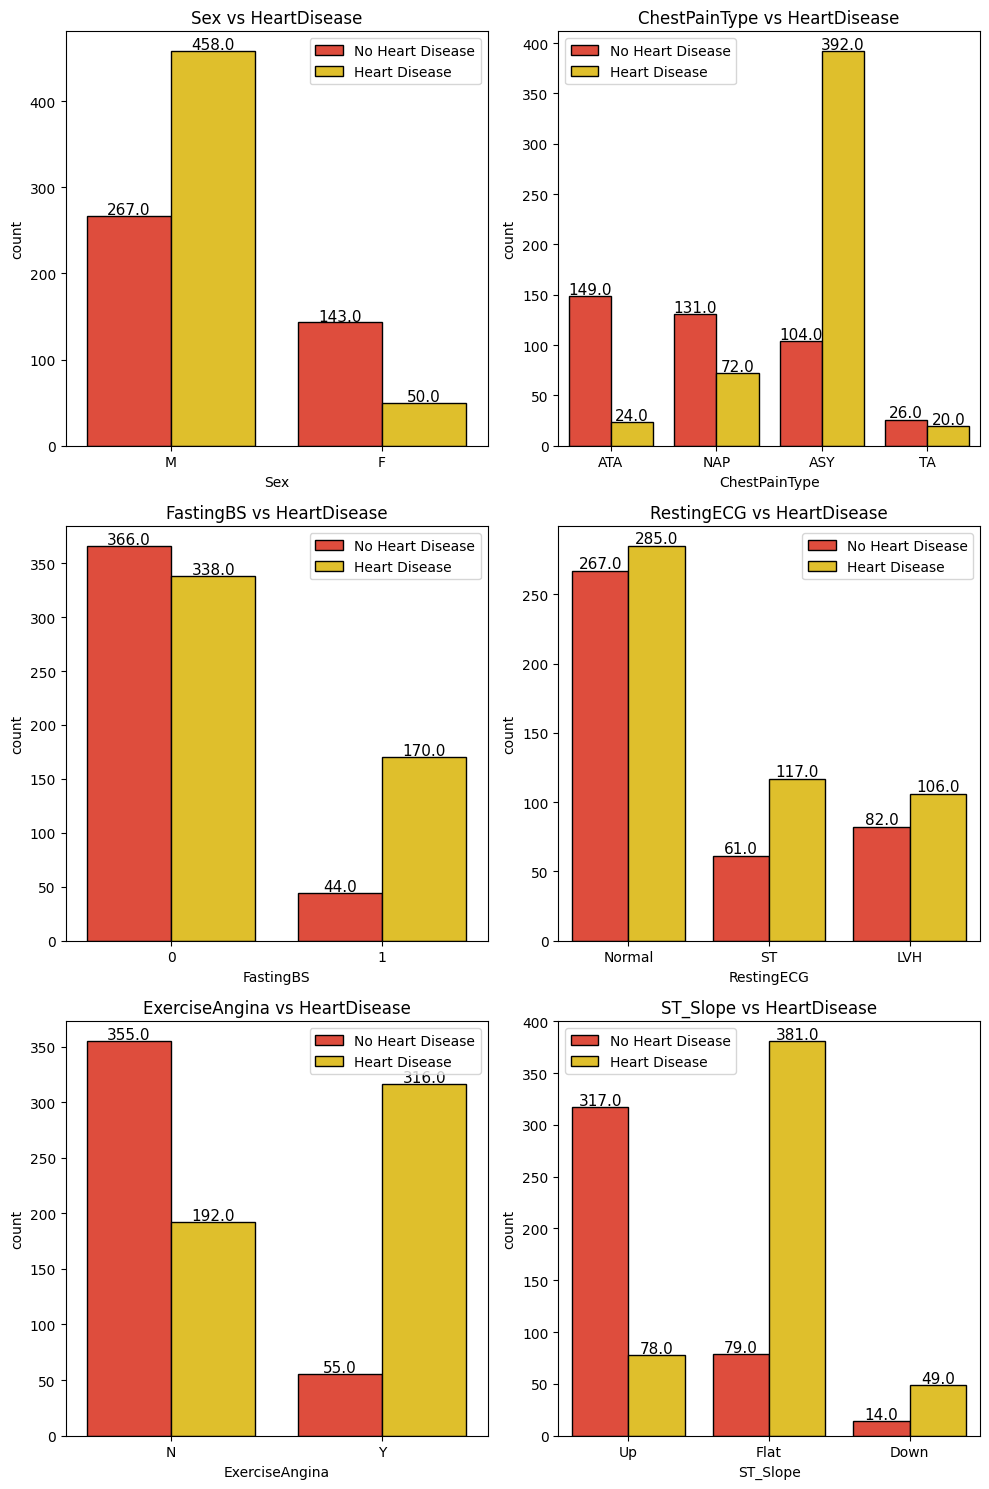

In [41]:
fig, ax = plt.subplots(nrows=3, ncols=2, figsize=(10, 15))

for i in range(len(categorical_features) - 1):
    plt.subplot(3, 2, i+1)
    sns.countplot(x=categorical_features[i], data=data, hue="HeartDisease", palette=colors, edgecolor='black')
    for rect in ax[i // 2, i % 2].patches:
        ax[i // 2, i % 2].text(rect.get_x() + rect.get_width() / 2, rect.get_height() + 2, rect.get_height(),
                               horizontalalignment='center', fontsize=11)
    title = categorical_features[i] + ' vs HeartDisease'
    plt.legend(['No Heart Disease', 'Heart Disease'])
    plt.title(title)

plt.tight_layout()
plt.show()

### Numerical Features vs Target Variable (HeartDisease) :

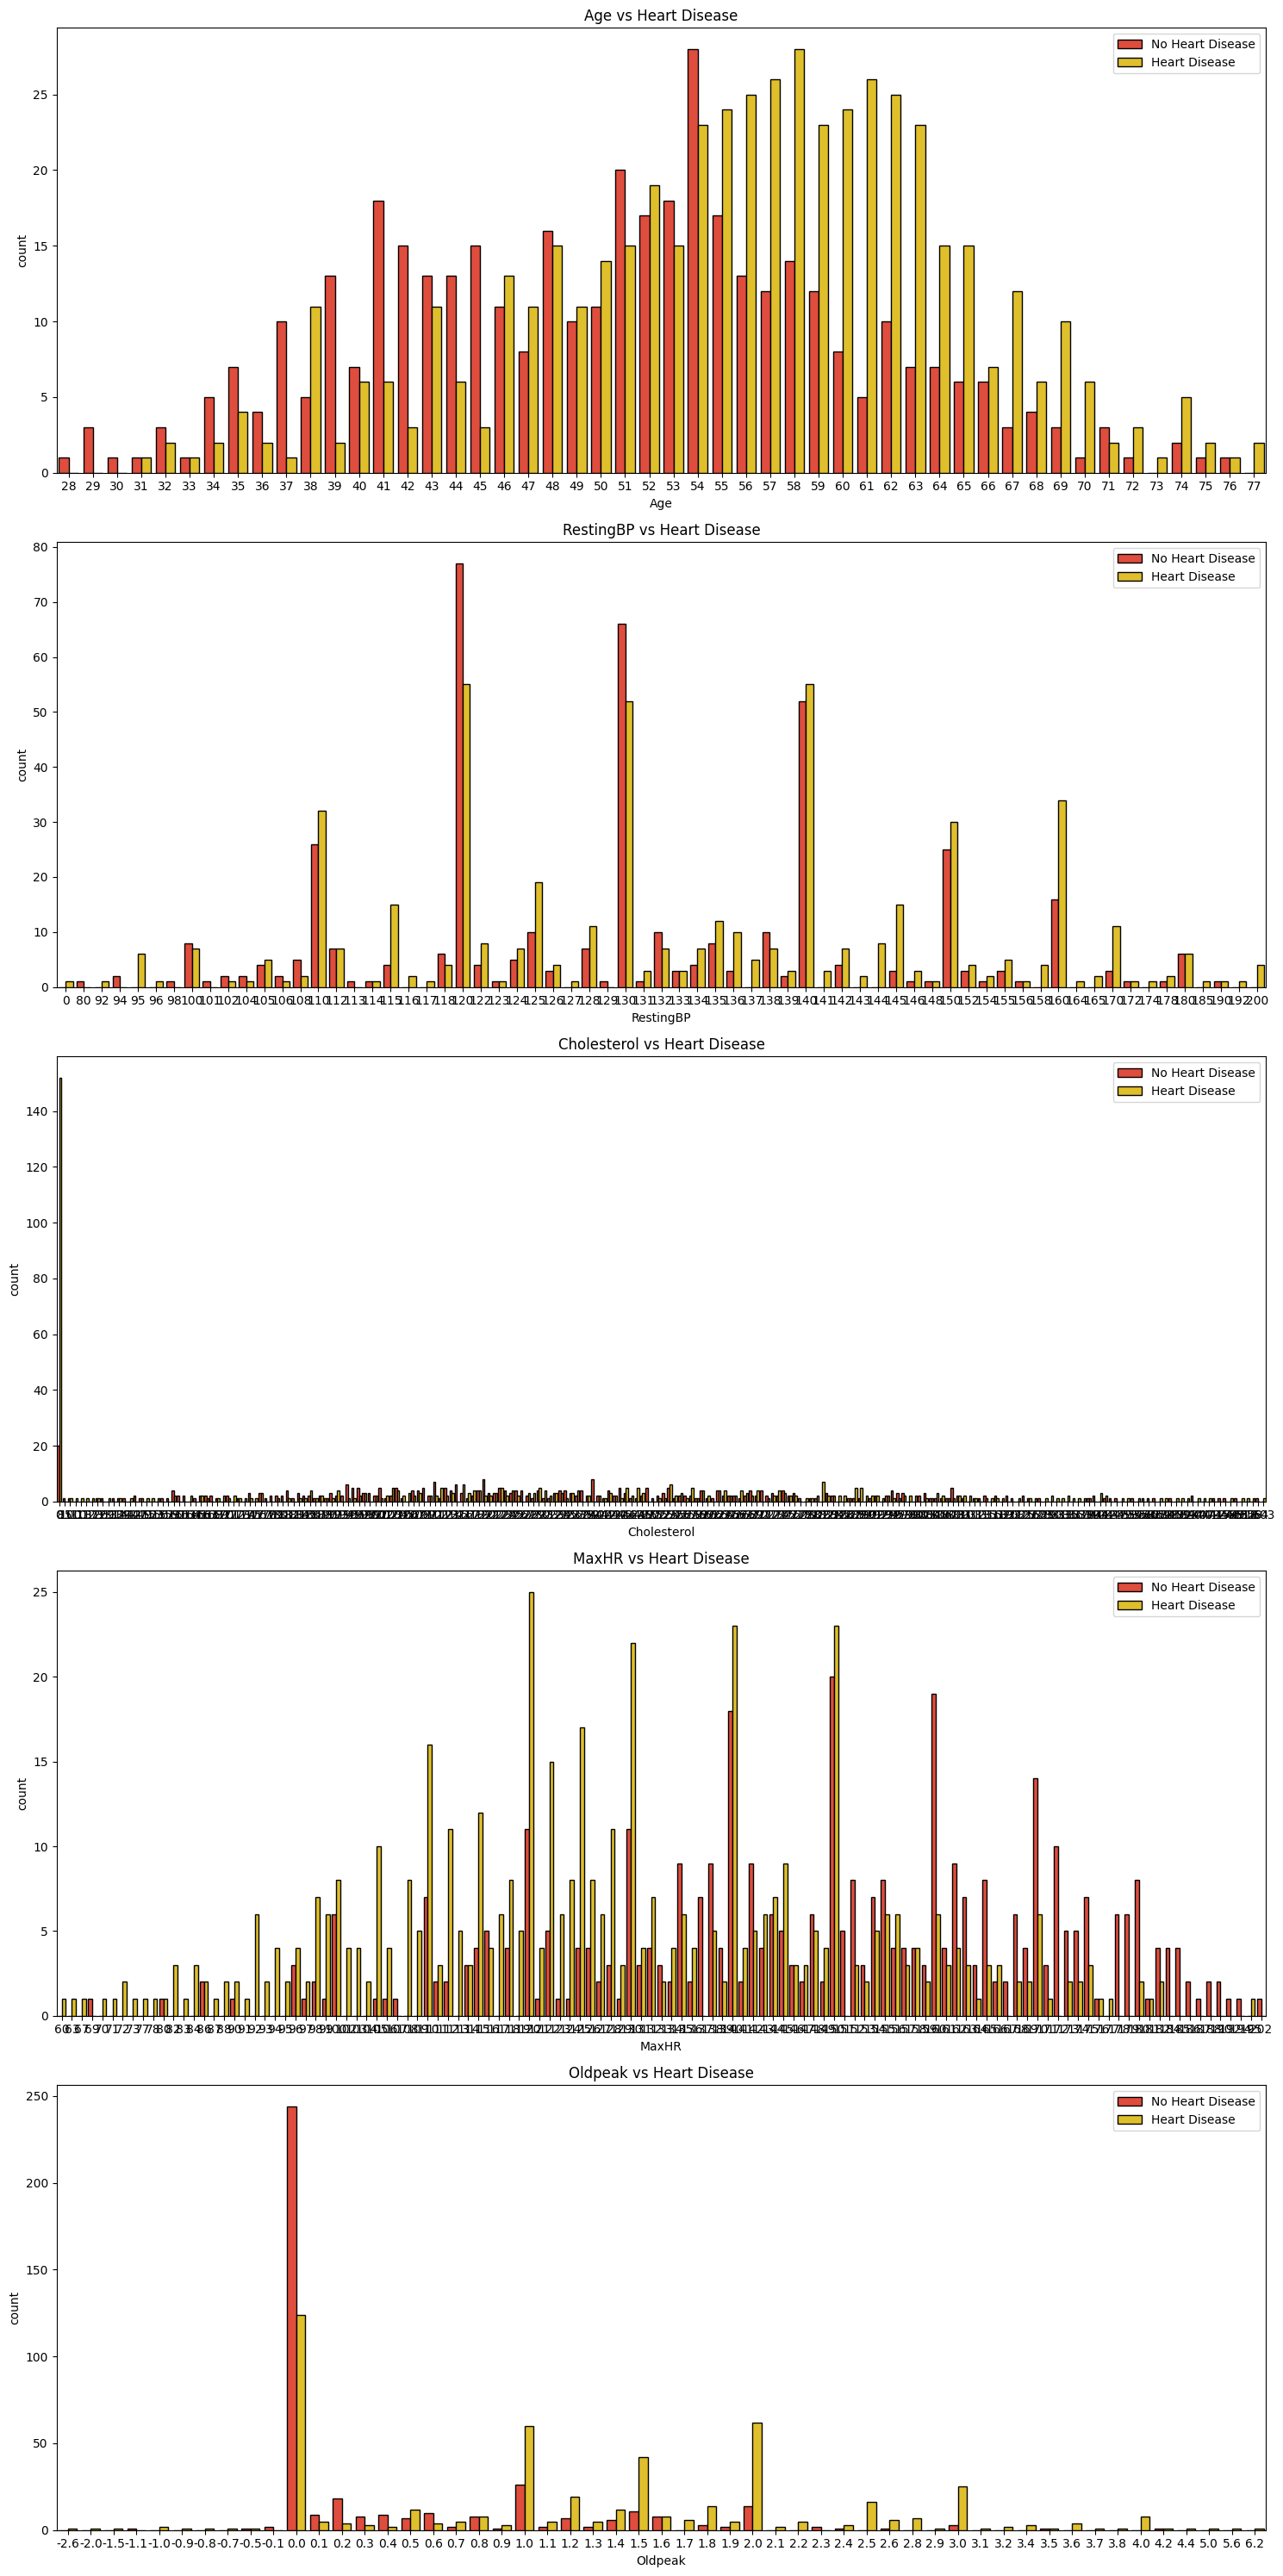

In [42]:
fig, ax = plt.subplots(nrows=5, ncols=1, figsize=(15, 30))

for i in range(len(numerical_features)):
    plt.subplot(5, 1, i+1)
    sns.countplot(x=numerical_features[i], hue="HeartDisease", data=data, palette=colors, edgecolor='black')
    title = numerical_features[i] + ' vs Heart Disease'
    plt.legend(['No Heart Disease', 'Heart Disease'])
    plt.title(title)

plt.tight_layout()
plt.show()

In [43]:
data['RestingBP_Group'] = [ int(i / 5) for i in data['RestingBP']]
data['Cholesterol_Group'] = [ int(i / 10) for i in data['Cholesterol']]
data['MaxHR_Group'] = [ int(i / 5) for i in data['MaxHR']]
data['Oldpeak_Group'] = [ int( (i*10) / 5) for i in data['Oldpeak']]

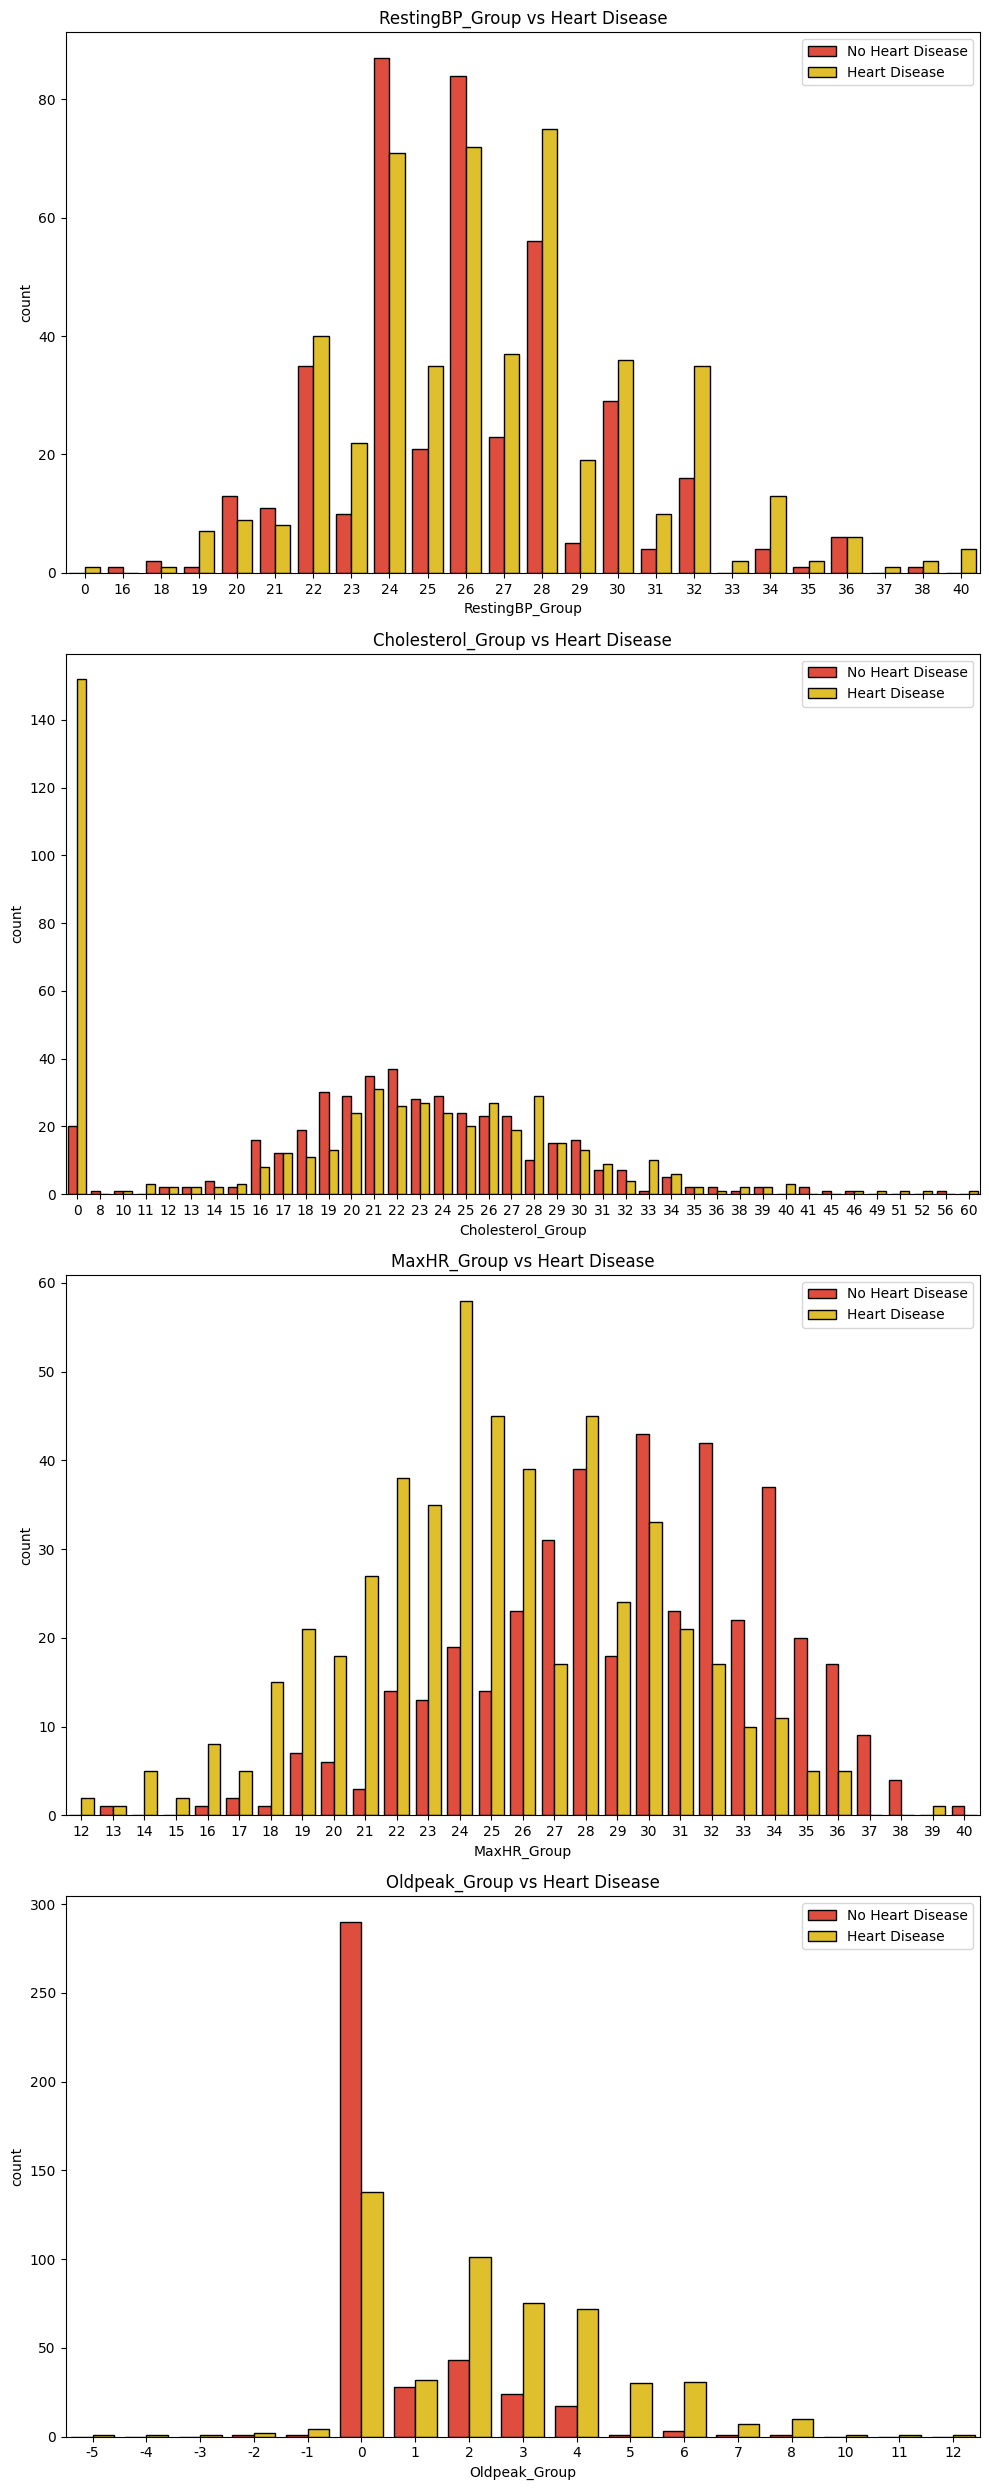

In [44]:
fig, ax = plt.subplots(nrows=4, ncols=1, figsize=(10, 25))
group_numerical_features = [i + '_Group' for i in numerical_features[1:]]

for i in range(len(group_numerical_features)):
    plt.subplot(4, 1, i+1)
    sns.countplot(x=group_numerical_features[i], hue="HeartDisease", data=data, palette=colors, edgecolor='black')
    plt.legend(['No Heart Disease', 'Heart Disease'])
    title = group_numerical_features[i] + ' vs Heart Disease'
    plt.title(title)

plt.tight_layout()
plt.show()

### Correlation Matrix :

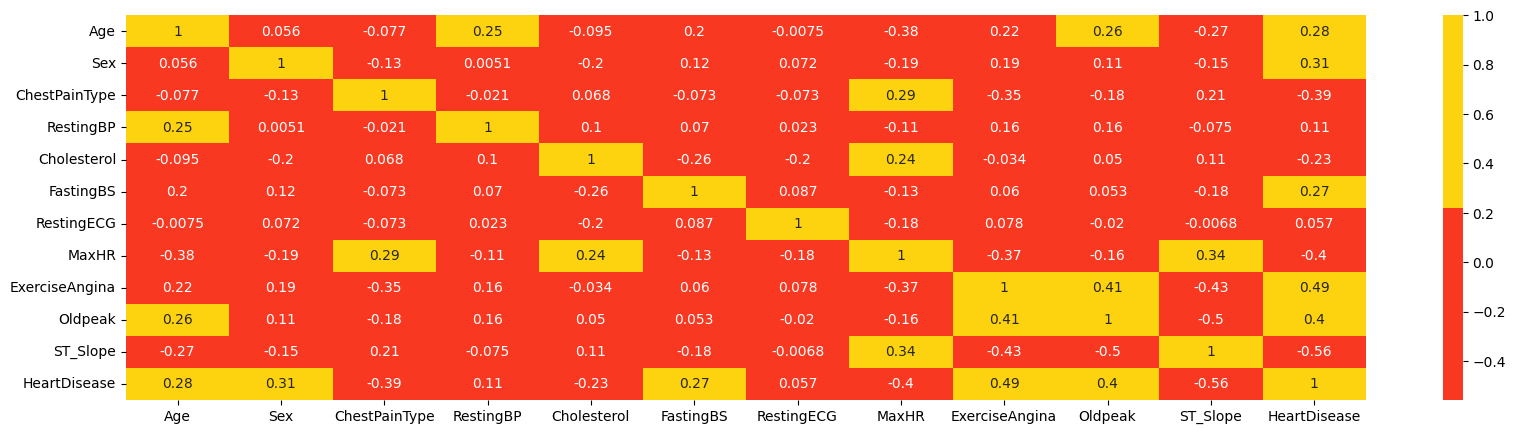

In [45]:
plt.figure(figsize = (20,5))
sns.heatmap(df1.corr(),cmap = colors,annot = True);

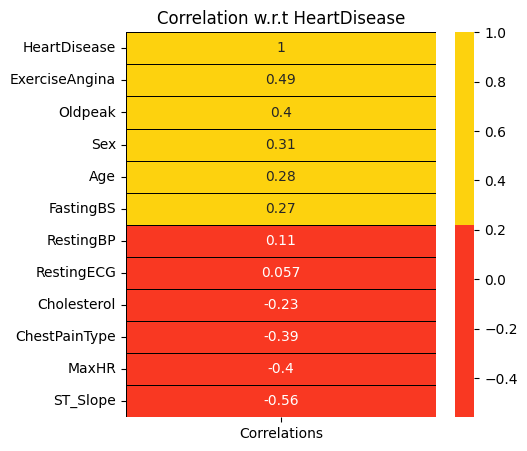

In [46]:
corr = df1.corrwith(df1['HeartDisease']).sort_values(ascending = False).to_frame()
corr.columns = ['Correlations']
plt.subplots(figsize = (5,5))
sns.heatmap(corr,annot = True,cmap = colors,linewidths = 0.4,linecolor = 'black');
plt.title('Correlation w.r.t HeartDisease');

#modeling

In [48]:
# Separate features (X) and target variable (y)
X = data.drop('HeartDisease', axis=1)
y = data['HeartDisease']

# Split the dataset into training and test sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=0)

# Preprocess the categorical variables using one-hot encoding
categorical_features = ['Sex', 'ChestPainType', 'FastingBS', 'RestingECG', 'ExerciseAngina', 'ST_Slope']
numeric_features = ['Age', 'RestingBP', 'Cholesterol', 'MaxHR', 'Oldpeak']

preprocessor = ColumnTransformer([
    ('encoder', OneHotEncoder(drop='first'), categorical_features),
    ('scaler', StandardScaler(), numeric_features)
])

X_train_preprocessed = preprocessor.fit_transform(X_train)
X_test_preprocessed = preprocessor.transform(X_test)

# Define the models and their respective parameters
k_values = [2, 5, 7, 10, 15, 20]
svm_kernels = ['linear', 'poly', 'rbf']
models = []
model_names = []

# K-Nearest Neighbors
for k in k_values:
    knn = KNeighborsClassifier(n_neighbors=k)
    models.append(knn)
    model_names.append(f'KNN (K={k})')

# Support Vector Machines
for kernel in svm_kernels:
    svm = SVC(kernel=kernel)
    models.append(svm)
    model_names.append(f'SVM ({kernel.capitalize()})')

# Logistic Regression
logreg = LogisticRegression()
models.append(logreg)
model_names.append('Logistic Regression')

# Random Forest
rf = RandomForestClassifier(random_state=0)
models.append(rf)
model_names.append('Random Forest')

#results

KNN (K=2):
  Accuracy: 0.7880
  Precision: 0.8778
  Recall: 0.7383
  F1-Score: 0.8020
  Confusion Matrix:
[[66 11]
 [28 79]]


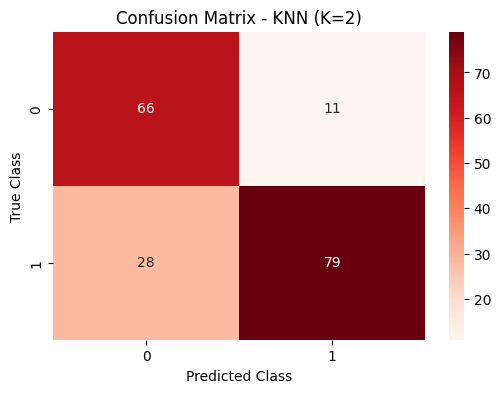


KNN (K=5):
  Accuracy: 0.8533
  Precision: 0.8636
  Recall: 0.8879
  F1-Score: 0.8756
  Confusion Matrix:
[[62 15]
 [12 95]]


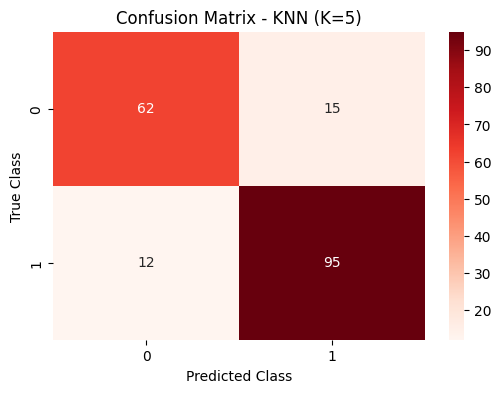


KNN (K=7):
  Accuracy: 0.8370
  Precision: 0.8407
  Recall: 0.8879
  F1-Score: 0.8636
  Confusion Matrix:
[[59 18]
 [12 95]]


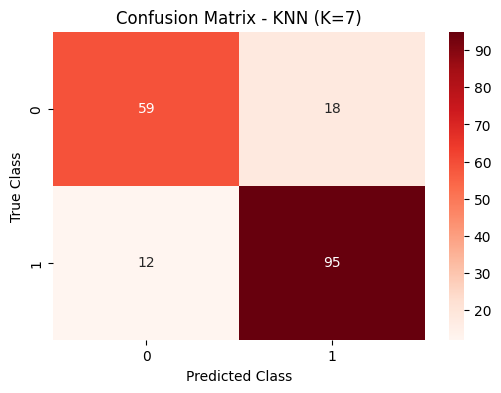


KNN (K=10):
  Accuracy: 0.8696
  Precision: 0.8739
  Recall: 0.9065
  F1-Score: 0.8899
  Confusion Matrix:
[[63 14]
 [10 97]]


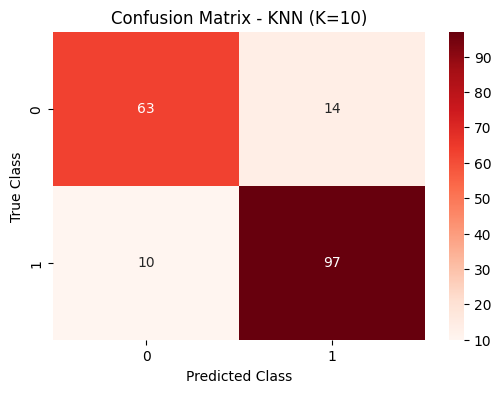


KNN (K=15):
  Accuracy: 0.8587
  Precision: 0.8584
  Recall: 0.9065
  F1-Score: 0.8818
  Confusion Matrix:
[[61 16]
 [10 97]]


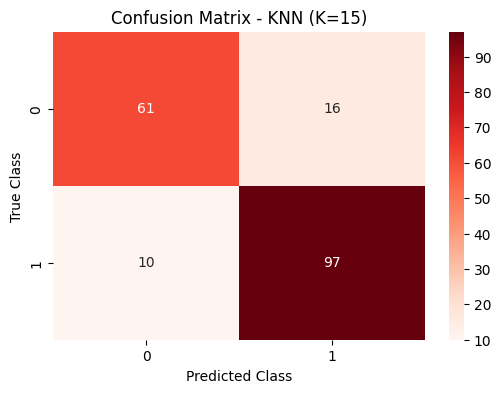


KNN (K=20):
  Accuracy: 0.8478
  Precision: 0.8624
  Recall: 0.8785
  F1-Score: 0.8704
  Confusion Matrix:
[[62 15]
 [13 94]]


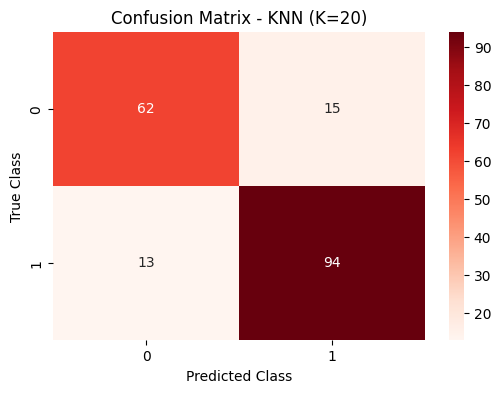


SVM (Linear):
  Accuracy: 0.8424
  Precision: 0.8421
  Recall: 0.8972
  F1-Score: 0.8688
  Confusion Matrix:
[[59 18]
 [11 96]]


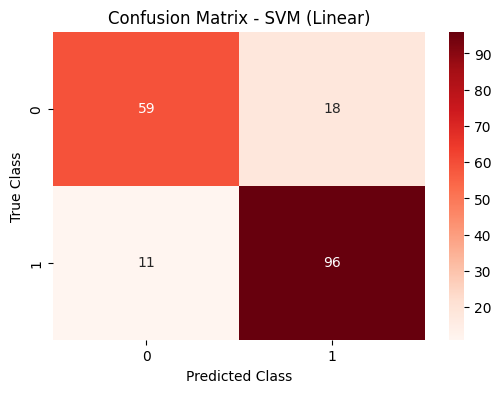


SVM (Poly):
  Accuracy: 0.8641
  Precision: 0.8796
  Recall: 0.8879
  F1-Score: 0.8837
  Confusion Matrix:
[[64 13]
 [12 95]]


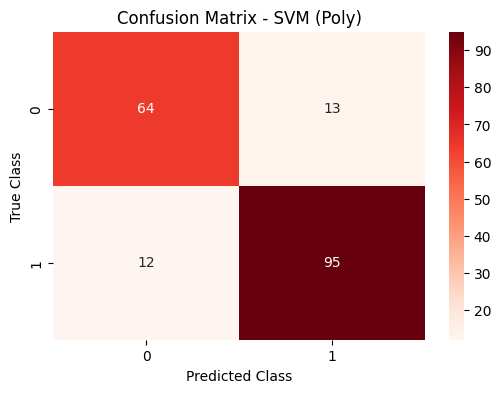


SVM (Rbf):
  Accuracy: 0.8478
  Precision: 0.8496
  Recall: 0.8972
  F1-Score: 0.8727
  Confusion Matrix:
[[60 17]
 [11 96]]


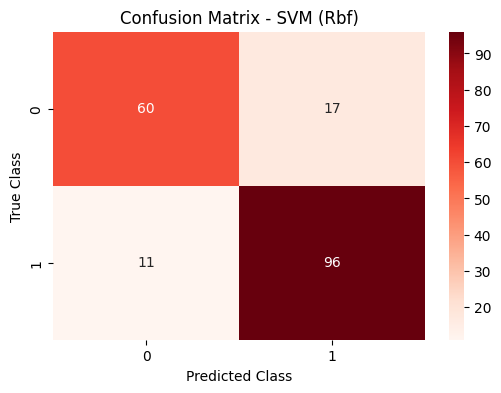


Logistic Regression:
  Accuracy: 0.8370
  Precision: 0.8291
  Recall: 0.9065
  F1-Score: 0.8661
  Confusion Matrix:
[[57 20]
 [10 97]]


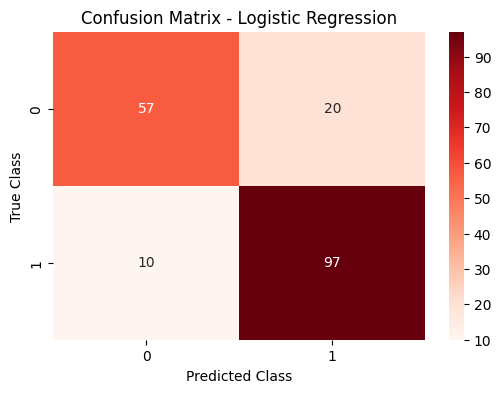


Random Forest:
  Accuracy: 0.8696
  Precision: 0.8739
  Recall: 0.9065
  F1-Score: 0.8899
  Confusion Matrix:
[[63 14]
 [10 97]]


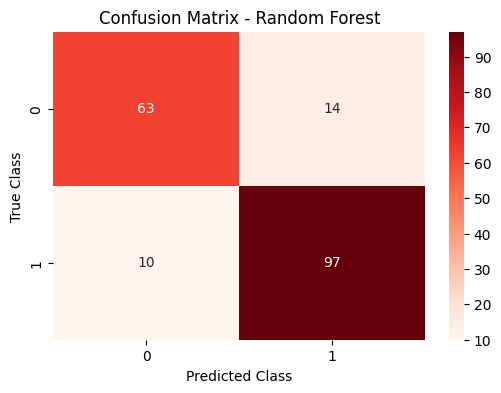

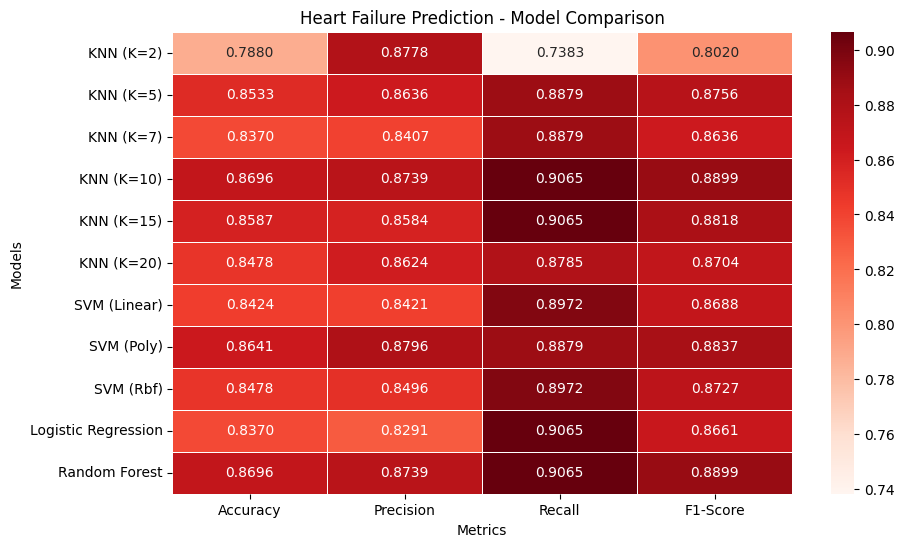

In [49]:
# Evaluation metrics
results = []
for model, model_name in zip(models, model_names):
    model.fit(X_train_preprocessed, y_train)
    y_pred = model.predict(X_test_preprocessed)

    accuracy = accuracy_score(y_test, y_pred)
    precision = precision_score(y_test, y_pred)
    recall = recall_score(y_test, y_pred)
    f1 = f1_score(y_test, y_pred)
    cm = confusion_matrix(y_test, y_pred)

    results.append((model_name, accuracy, precision, recall, f1, cm))

# Print evaluation metrics and plot confusion matrices
for result in results:
    model_name, accuracy, precision, recall, f1, cm = result
    print(f'{model_name}:')
    print(f'  Accuracy: {accuracy:.4f}')
    print(f'  Precision: {precision:.4f}')
    print(f'  Recall: {recall:.4f}')
    print(f'  F1-Score: {f1:.4f}')
    print(f'  Confusion Matrix:\n{cm}')

    plt.figure(figsize=(6, 4))
    sns.heatmap(cm, annot=True, fmt='d', cmap='Reds')
    plt.title(f'Confusion Matrix - {model_name}')
    plt.xlabel('Predicted Class')
    plt.ylabel('True Class')
    plt.show()
    print()

# Create a heatmap of the overall results
metrics = ['Accuracy', 'Precision', 'Recall', 'F1-Score']
metric_scores = np.zeros((len(models), len(metrics)))

for i, result in enumerate(results):
    model_name, accuracy, precision, recall, f1, _ = result
    metric_scores[i] = [accuracy, precision, recall, f1]

df_metrics = pd.DataFrame(metric_scores, columns=metrics, index=model_names)

plt.figure(figsize=(10, 6))
sns.heatmap(df_metrics, annot=True, cmap='Reds', fmt='.4f', cbar=True, linewidths=0.5)
plt.title('Heart Failure Prediction - Model Comparison')
plt.xlabel('Metrics')
plt.ylabel('Models')
plt.show()